# 📡 QPSK: Single-Carrier vs OFDM (1 Subcarrier) + Channel Effects & BER Simulation


This notebook compares:
- **Single-carrier QPSK with pulse shaping**
- **OFDM with one subcarrier**

and adds:
- **AWGN channel**
- **Bit Error Rate (BER) analysis**
- **Visualizations of constellation before and after the channel**

Each scheme is explored step-by-step.


## 🔹 Setup & Symbol Generation

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.fft import ifft, fft
from numpy.random import default_rng

rng = default_rng(42)

# Parameters
num_symbols = 1000
samples_per_symbol = 8
fs = 1e4
fc = 2e3
rolloff = 0.35
span = 6
fft_size = 64
cp_length = 16
snr_db = 10

# Generate random QPSK symbols
bits = rng.integers(0, 2, 2 * num_symbols)
symbols = (2 * bits[::2] - 1) + 1j * (2 * bits[1::2] - 1)
symbols /= np.sqrt(2)


## 🔸 Single-Carrier QPSK Modulation

In [2]:

def rrc_filter(beta, sps, span):
    N = span * sps
    t = np.arange(-N / 2, N / 2 + 1) / sps
    h = np.sinc(t) * np.cos(np.pi * beta * t) / (1 - (2 * beta * t)**2)
    h[t == 0.5 / beta] = np.pi / 4 * np.sinc(1 / (2 * beta))
    h[t == -0.5 / beta] = np.pi / 4 * np.sinc(1 / (2 * beta))
    return h / np.sqrt(np.sum(h**2))

pulse = rrc_filter(rolloff, samples_per_symbol, span)
i_upsampled = np.zeros(num_symbols * samples_per_symbol)
q_upsampled = np.zeros_like(i_upsampled)
i_upsampled[::samples_per_symbol] = np.real(symbols)
q_upsampled[::samples_per_symbol] = np.imag(symbols)

i_shaped = convolve(i_upsampled, pulse, mode='same')
q_shaped = convolve(q_upsampled, pulse, mode='same')
baseband = i_shaped + 1j * q_shaped
t_total = np.arange(len(baseband)) / fs
carrier = np.exp(1j * 2 * np.pi * fc * t_total)
rf_sc = np.real(baseband * carrier)


## 🔸 OFDM Modulation (Single Subcarrier)

In [3]:

ofdm_symbols = symbols[:int(len(symbols))]
ofdm_grid = np.zeros((len(ofdm_symbols), fft_size), dtype=complex)
ofdm_grid[:, 1] = ofdm_symbols

ofdm_time = ifft(ofdm_grid, axis=1)
ofdm_with_cp = np.hstack([ofdm_time[:, -cp_length:], ofdm_time])
ofdm_serial = ofdm_with_cp.ravel()

t_ofdm = np.arange(len(ofdm_serial)) / fs
carrier_ofdm = np.exp(1j * 2 * np.pi * fc * t_ofdm)
rf_ofdm = np.real(ofdm_serial * carrier_ofdm)


## 🌩 Channel + BER Simulation

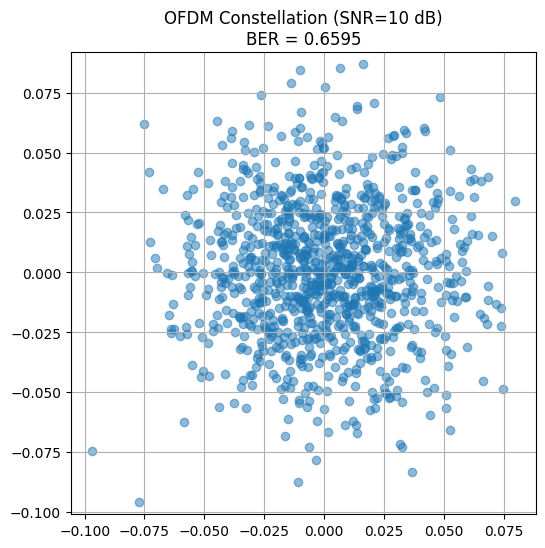

In [4]:

def awgn(signal, snr_db):
    snr = 10**(snr_db / 10)
    power = np.mean(np.abs(signal)**2)
    noise_power = power / snr
    noise = np.sqrt(noise_power / 2) * (rng.standard_normal(signal.shape) + 1j * rng.standard_normal(signal.shape))
    return signal + noise

# Transmit through AWGN
rx_ofdm = awgn(ofdm_serial, snr_db)
rx_time = rx_ofdm * np.exp(-1j * 2 * np.pi * fc * t_ofdm)  # Downconvert
rx_blocks = rx_time.reshape((-1, fft_size + cp_length))[:, cp_length:]
rx_freq = fft(rx_blocks, axis=1)
rx_symbols = rx_freq[:, 1]

# Demodulate and calculate BER
rx_bits = np.empty(2 * len(rx_symbols), dtype=int)
rx_bits[0::2] = np.real(rx_symbols) > 0
rx_bits[1::2] = np.imag(rx_symbols) > 0
ber = np.mean(rx_bits != bits[:len(rx_bits)])

plt.figure(figsize=(6, 6))
plt.scatter(np.real(rx_symbols), np.imag(rx_symbols), alpha=0.5)
plt.title(f"OFDM Constellation (SNR={snr_db} dB)\nBER = {ber:.4f}")
plt.grid(True)
plt.axis("equal")
plt.show()


## 📈 Channel Impulse Response Visualization

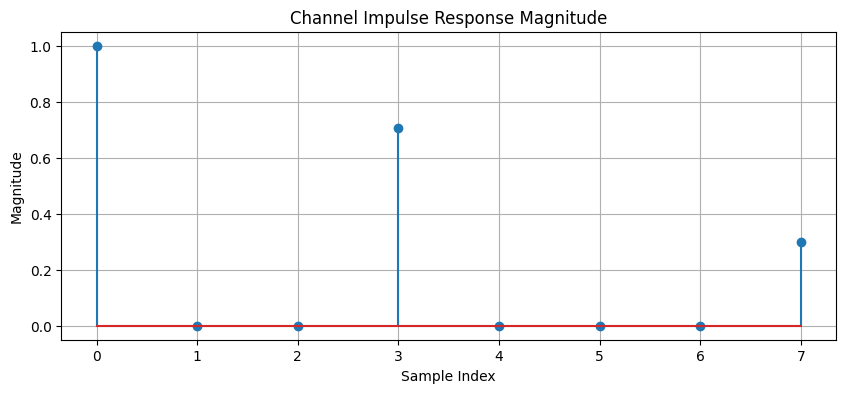

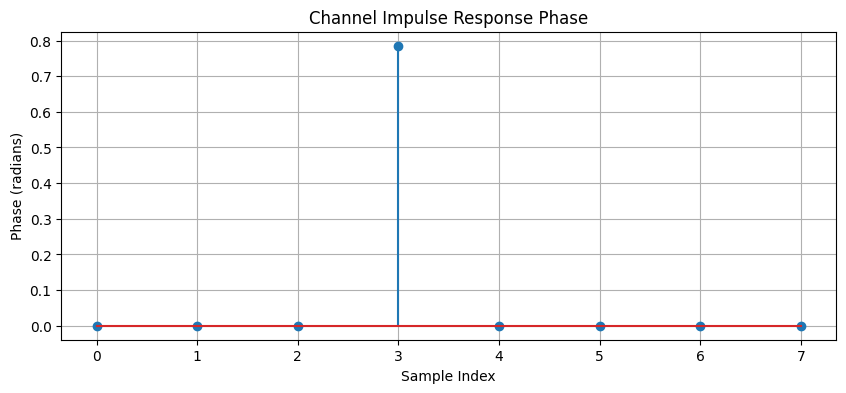

In [6]:

# Define impulse response for illustrative fading channel
channel_taps = np.array([1.0, 0.5 + 0.5j, 0.3])
channel_delays = np.array([0, 3, 7])
impulse_response = np.zeros(channel_delays[-1] + 1, dtype=complex)
impulse_response[channel_delays] = channel_taps

# Plot impulse response (magnitude and phase)
plt.figure(figsize=(10, 4))
plt.stem(np.abs(impulse_response))
plt.title("Channel Impulse Response Magnitude")
plt.xlabel("Sample Index"); plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.stem(np.angle(impulse_response))
plt.title("Channel Impulse Response Phase")
plt.xlabel("Sample Index"); plt.ylabel("Phase (radians)")
plt.grid(True)
plt.show()
